In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
import re
from collections import Counter
from sklearn.linear_model import LogisticRegression

For this project, I will use data from Goodreads and the New York Times Books API to predict New York Times Bestsellers. The Goodreads data was available [here](https://github.com/zygmuntz/goodbooks-10k) and [here](https://www.kaggle.com/brosen255/goodreads-books). I also looked into using the additional Goodreads data available [here](https://www.kaggle.com/meetnaren/goodreads-best-books), and [here](https://www.kaggle.com/meetnaren/goodreads-best-books-of-2018), but that data unfortunately did not contain the full isbns for the books, and therefore could not be merged with the rest of the data.

The first set of data is included in several different csv files. I will begin by combining several of these files into a single dataframe. First, I will load the books file, which contains information about 10,000 books.

In [2]:
#load data
book_df = pd.read_csv('books.csv')
book_df.head()

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


Next, I will import the "to read" file, which contains information on which books users have marked as to-read.

In [3]:
#load to-read file
to_read_df = pd.read_csv('to_read.csv')
to_read_df.head()

,user_id,book_id
0,9,8
1,15,398
2,15,275
3,37,7173
4,34,380


Since we want our data to be organized by book, I will get the value counts for each book and store those values in a column called to read count. As stated in the dataset documentation, book id in this file is equivalent to work id in the full book dataset, so I will update the name of that column as well.

In [4]:
#get value counts of to-read and rename columns
to_read_counts = to_read_df['book_id'].value_counts()
to_read_counts = to_read_counts.rename_axis('work_id').reset_index(name='to_read_count')
to_read_counts

,work_id,to_read_count
0,47,2772
1,143,1967
2,113,1840
3,13,1812
4,11,1767
...,...,...
9981,9125,1
9982,6656,1
9983,9838,1
9984,9724,1


Next, I will add this column to the main book dataframe using the work id. I will keep all of the rows in the book dataframe.

In [5]:
#merge book and to read data
book_df = book_df.merge(to_read_counts, on = 'work_id', how = 'left')

There is also information on the tags that have been used to describe each book. This information is contained in the book tags file, and information on the tag names is contained in the tags file.

In [6]:
#load book tag data
book_tags_df = pd.read_csv('book_tags.csv')
book_tags_df.head()

,goodreads_book_id,tag_id,count
0,1,30574,167697
1,1,11305,37174
2,1,11557,34173
3,1,8717,12986
4,1,33114,12716


In [7]:
#load tag data
tags_df = pd.read_csv('tags.csv')
tags_df.head()

,tag_id,tag_name
0,0,-
1,1,--1-
2,2,--10-
3,3,--12-
4,4,--122-


Next, we want to add a column for tag name to the book tags dataframe. We will keep all of the rows in the book tags dataframe, and will not keep tags for which no books were tagged.

In [8]:
#combine book tags and tags dataframes
book_tags_df = book_tags_df.merge(tags_df, how = 'left')

Now we want to get information on which tags are the most popular. We will do this by taking only the tags that are listed at least 1000 times, i.e. tags that apply to at least 1000 books.

In [9]:
#get tag counts
tag_counts = book_tags_df['tag_name'].value_counts()
tag_counts = tag_counts.rename_axis('tag_name').reset_index(name='tag_count')
#get most popular tags
tag_counts_short = tag_counts[tag_counts['tag_count'] > 1000]
tag_counts_short

,tag_name,tag_count
0,to-read,9983
1,favorites,9881
2,owned,9858
3,books-i-own,9799
4,currently-reading,9776
...,...,...
181,childrens-books,1013
182,england,1013
183,ya-fantasy,1012
184,crime-mystery,1011


In [10]:
#save list of most popular tags
tag_list = ['to-read', 'favorites', 'owned', 'books-i-own', 'currently-reading', 'library', 'owned-books', 'fiction',
            'to-buy', 'kindle', 'default', 'ebook', 'my-books', 'audiobook', 'ebooks', 'wish-list', 'my-library',
            'audiobooks', 'i-own', 'adult', 'audio', 'favourites', 'novels', 'own-it', 'contemporary', 'read-in-2015',
            'series', 'e-book', 'read-in-2016', 'read-in-2014', 'books', 'adult-fiction', 'e-books', 'read-in-2013', 
            'book-club', 'audible', 'fantasy', 'romance', 'audio-books', 'abandoned', 'novel', 're-read', 'have',
            'audio-book', 'mystery', 'borrowed', 'adventure', 'read-in-2012', 'young-adult', 'english', 'did-not-finish',
            'favorite', 'maybe', 'shelfari-favorites', 'drama', 'literature', 'general-fiction', 'read-2015', 'ya',
            'all-time-favorites', 'classics', 'read-2016', 'read-2014', 'contemporary-fiction', 'favorite-books', 'dnf',
            'finished', 'read-in-2011', 'read-in-2017', '5-stars', 'historical-fiction', 'paperback', 'historical', 
            'thriller', 'sci-fi-fantasy', 'american', 'suspense', 'reviewed', '4-stars', 'unfinished', 'read-2013',
            'home-library', 'library-books', 'sci-fi', 'science-fiction', 'action', 'humor', 'family', 'history',
            'non-fiction', 'calibre', 'crime', 'didn-t-finish', 'to-read-fiction', 'fantasy-sci-fi', 'nook', 'library-book',
            'chick-lit', '20th-century', 'paranormal', 'school', 'classic', 'magic', 'mystery-thriller', 'teen',
            'supernatural', 'recommended', 'nonfiction', 'favorite-authors', 'realistic-fiction', 'literary-fiction',
            'bookclub', 'want-to-read', 'read-in-2010', 'tbr', 'unread', 'funny', 'bookshelf', 'scifi-fantasy', 'love',
            'part-of-a-series', 'books-i-have', 'ya-fiction', 'mystery-suspense', 'kindle-books', 'own-to-read',
            'read-2012', 'mysteries', 'must-read', 'need-to-buy', 'urban-fantasy', 'childhood', 'read-in-english', 
            'children', 'literary', 'horror', 'reread', 'childrens', 'young-adult-fiction', 'thrillers', 'read-2017',
            '2015-reads', 'on-my-shelf', 'british', '2016-reads', 'children-s', 'coming-of-age', 'kids', 'on-kindle',
            'favorite-series', 'science-fiction-fantasy', 'science', 'friendship', 'on-hold', 'listened-to',
            'children-s-books', '2014-reads', 'general', 'ya-books', 'my-favorites', 'scifi', 'action-adventure', 'humour',
            'biography', 'speculative-fiction', 'contemporary-romance', 'high-school', 'to-read-non-fiction', 'women',
            'philosophy', '3-stars', 'war', 'fantasy-scifi', 'mystery-crime', 'usa', 'shelfari-wishlist',
            'first-in-series', 'comedy', 'juvenile', 'suspense-thriller', 'stand-alone', 'childrens-books', 'england',
            'ya-fantasy', 'crime-mystery', 'kids-books']

I will drop the rows with duplicate combinations of Goodreads book id and tag name, and then pivot the dataframe, so that the index is the Goodreads book id, the columns are the tag name, and the values are the tag count. Then I will reset the index so that Goodreads book id is a column that we can work with, and then select the columns in the dataframe for the most popular tags, as listed above.

In [11]:
#drop duplicates
book_tags_df = book_tags_df.drop_duplicates(subset = ['goodreads_book_id', 'tag_name'])
#pivot dataframe
book_tags_df = book_tags_df.pivot(index='goodreads_book_id', columns='tag_name', values='count')
#reset index
book_tags_df = book_tags_df.rename_axis(None, axis=1).reset_index()
book_tags_df

,goodreads_book_id,-,--1-,--10-,--12-,--122-,--166-,--17-,--19-,--2-,...,漫画,골든,﹏moonplus-reader﹏,ﺭﺿﻮﻯ-عاشور,ﻳﻮﺳﻒ-زيدان,Ｃhildrens,Ｆａｖｏｒｉｔｅｓ,Ｍａｎｇａ,ＳＥＲＩＥＳ,ｆａｖｏｕｒｉｔｅｓ
0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,31538647,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9996,31845516,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9997,32075671,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9998,32848471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
#select columns for most popular tags
book_tags_df = book_tags_df[['goodreads_book_id'] + tag_list]

Again, I will merge this modified version of the dataframe with the main book dataframe, keeping all values in the book dataframe.

In [13]:
#merge book tags with books
book_df = book_df.merge(book_tags_df, on = 'goodreads_book_id', how = 'left')

In [14]:
book_df

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,first-in-series,comedy,juvenile,suspense-thriller,stand-alone,childrens-books,england,ya-fantasy,crime-mystery,kids-books
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,399.0,NaN,NaN
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,NaN,NaN,533.0,NaN,NaN,701.0,359.0,739.0,NaN,498.0
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,194.0,NaN,NaN,NaN,NaN,NaN,NaN,465.0,NaN,NaN
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,NaN,NaN,NaN,NaN,196.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,7130616,7130616,7392860,19,441019455,9.780441e+12,Ilona Andrews,2010.0,Bayou Moon,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9996,9997,208324,208324,1084709,19,067973371X,9.780680e+12,Robert A. Caro,1990.0,Means of Ascent,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9997,9998,77431,77431,2393986,60,039330762X,9.780393e+12,Patrick O'Brian,1977.0,The Mauritius Command,...,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN
9998,9999,8565083,8565083,13433613,7,61711527,9.780062e+12,Peggy Orenstein,2011.0,Cinderella Ate My Daughter: Dispatches from th...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Next, I will start working with the author data available [here](https://www.kaggle.com/brosen255/goodreads-books).

In [15]:
#load author based data
author_df =pd.read_csv('good_reads_final.csv')
author_df

,author_average_rating,author_gender,author_genres,author_id,author_name,author_page_url,author_rating_count,author_review_count,birthplace,book_average_rating,book_fullurl,book_id,book_title,genre_1,genre_2,num_ratings,num_reviews,pages,publish_date,score
0,4.01,female,"historical-fiction,",74489,Victoria Thompson\n,/author/show/74489.Victoria_Thompson,74399,6268,United States\n,4.02,https://www.goodreads.com/book/show/686717.Mur...,686717,\n Murder on St. Mark's Place\n,Mystery,Historical,5260,375,277,2000,3230
1,4.15,male,"literature-fiction,mystery-thrillers,",706255,Stieg Larsson\n,/author/show/706255.Stieg_Larsson,3726435,142704,Sweden\n,4.13,https://www.goodreads.com/book/show/2429135.Th...,2429135,\n The Girl with the Dragon Tattoo\n,Fiction,Mystery,2229163,65227,465,August 2005,3062
2,4.00,female,"romance,",5618190,Mimi Jean Pamfiloff\n,/author/show/5618190.Mimi_Jean_Pamfiloff,76496,7975,United States\n,3.99,https://www.goodreads.com/book/show/27833684-t...,27833684,\n Tailored for Trouble\n,Romance,Contemporary,2151,391,354,2016,4585
3,3.88,male,"fiction,memoir,",37871,José Donoso\n,/author/show/37871.Jos_Donoso,5522,489,Chile\n,4.14,https://www.goodreads.com/book/show/382975.The...,382975,\n The Obscene Bird of Night\n,Fiction,Magical Realism,1844,173,438,1970,1533
4,4.10,female,"young-adult,fantasy,",36122,Patricia C. Wrede\n,/author/show/36122.Patricia_C_Wrede,291013,13453,United States\n,4.01,https://www.goodreads.com/book/show/64207.Sorc...,64207,\n Sorcery & Cecelia: or The Enchanted Ch...,Fantasy,Young Adult,17051,1890,326,April 15th 1988,2105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22886,3.94,female,"humor-and-comedy,",108007,Dakota Cassidy\n,/author/show/108007.Dakota_Cassidy,52944,4558,\n,3.82,https://www.goodreads.com/book/show/24614174-g...,24614174,\n Gotta Have Faith\n,Fantasy,Romance,430,33,72,2015,1215
22887,4.29,male,"suspense,",7063660,Joanne Jaytanie\n,/author/show/7063660.Joanne_Jaytanie,902,428,United States\n,4.56,https://www.goodreads.com/book/show/31429117-p...,31429117,\n Payton's Pursuit\n,Romance,Fantasy,82,57,342,2014,1321
22888,4.00,female,"romance,",6543639,Krystal Shannan\n,/author/show/6543639.Krystal_Shannan,15626,3530,United States\n,3.73,https://www.goodreads.com/book/show/35892811-m...,35892811,\n My Viking Vampire\n,Fantasy,Paranormal,2698,375,237,January 1st 2014,1679
22889,4.20,female,"paranormal,",5246010,Bryce Evans\n,/author/show/5246010.Bryce_Evans,4689,828,\n,3.89,https://www.goodreads.com/book/show/17187320-t...,17187320,\n The Trinity\n,Fantasy,Paranormal,356,38,222,December 28th 2012,1897


It is immediately evident that the book title and author name columns need some cleaning to remove the "\n"'s, so I will go ahead and remove those now.

In [16]:
#clean title column
author_df['book_title'] = author_df['book_title'].str.replace('\n ', '')
author_df['book_title'] = author_df['book_title'].str.replace('\n', '')
#clean author column
author_df['author_name'] =  author_df['author_name'].str.replace('\n', '')
author_df.head()

,author_average_rating,author_gender,author_genres,author_id,author_name,author_page_url,author_rating_count,author_review_count,birthplace,book_average_rating,book_fullurl,book_id,book_title,genre_1,genre_2,num_ratings,num_reviews,pages,publish_date,score
0,4.01,female,"historical-fiction,",74489,Victoria Thompson,/author/show/74489.Victoria_Thompson,74399,6268,United States\n,4.02,https://www.goodreads.com/book/show/686717.Mur...,686717,Murder on St. Mark's Place,Mystery,Historical,5260,375,277,2000,3230
1,4.15,male,"literature-fiction,mystery-thrillers,",706255,Stieg Larsson,/author/show/706255.Stieg_Larsson,3726435,142704,Sweden\n,4.13,https://www.goodreads.com/book/show/2429135.Th...,2429135,The Girl with the Dragon Tattoo,Fiction,Mystery,2229163,65227,465,August 2005,3062
2,4.00,female,"romance,",5618190,Mimi Jean Pamfiloff,/author/show/5618190.Mimi_Jean_Pamfiloff,76496,7975,United States\n,3.99,https://www.goodreads.com/book/show/27833684-t...,27833684,Tailored for Trouble,Romance,Contemporary,2151,391,354,2016,4585
3,3.88,male,"fiction,memoir,",37871,José Donoso,/author/show/37871.Jos_Donoso,5522,489,Chile\n,4.14,https://www.goodreads.com/book/show/382975.The...,382975,The Obscene Bird of Night,Fiction,Magical Realism,1844,173,438,1970,1533
4,4.10,female,"young-adult,fantasy,",36122,Patricia C. Wrede,/author/show/36122.Patricia_C_Wrede,291013,13453,United States\n,4.01,https://www.goodreads.com/book/show/64207.Sorc...,64207,Sorcery & Cecelia: or The Enchanted Choco...,Fantasy,Young Adult,17051,1890,326,April 15th 1988,2105


Based on the urls in the author dataframe and the way that Goodreads formats their urls, I can see that the book id in this dataframe is equal to the Goodreads book id in the main book dataframe, so I will rename that column.

In [17]:
#rename book id column for ease of merging
author_df = author_df.rename(columns={"book_id": "goodreads_book_id"})

In order to merge these two dataframes, I need to convert the Goodreads book id in the author dataframe to numeric, first by removing unexpected characters. I will also drop rows with duplicate Goodreads book ids.

In [18]:
#remove non-numeric characters
author_df['goodreads_book_id'] = author_df['goodreads_book_id'].str.replace("']", "")
#convert book id to numeric
author_df['goodreads_book_id'] = author_df['goodreads_book_id'].apply(lambda x: float(x))
#drop duplicates
author_df = author_df.drop_duplicates(subset = 'goodreads_book_id')

Now, I will merge this dataframe with the book dataframe from above. For now, I will keep all of the rows in the original book dataframe.

In [19]:
book_df = book_df.merge(author_df, on = 'goodreads_book_id', how = 'left')
book_df.head()

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,book_average_rating,book_fullurl,book_title,genre_1,genre_2,num_ratings,num_reviews,pages,publish_date,score
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,4.27,https://www.goodreads.com/book/show/2657.To_Ki...,To Kill a Mockingbird,Classics,Fiction,3818591.0,81069.0,324,July 11th 1960,77418.0
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,3.91,https://www.goodreads.com/book/show/4671.The_G...,The Great Gatsby,Classics,Fiction,3202899.0,57834.0,180,1925,32216.0


Next, we will get our data on New York Times Best Sellers. This data was collected using the New York Times API. I collected data for hardcover fiction, hardcover nonfiction, paperback nonfiction, and paperback trade fiction from 2009 to present, as well as data on Young Adult Best Sellers from 2012 to 2015, and Young Adult Hardcover Bestsellers from 2015 to present.

In [20]:
#load NYT data
fic_df = pd.read_csv('nyt_fic.csv')
nonfic_df = pd.read_csv('nyt_nonfic.csv')
paper_fic_df = pd.read_csv('nyt_tradefic.csv')
paper_nonfic_df = pd.read_csv('nyt_paper_nonfic.csv')
ya_gen_df = pd.read_csv('nyt_ya.csv')
ya_hard_df = pd.read_csv('nyt_paper_yahard.csv')

In [21]:
#combine data into single dataframe
nyt_df = pd.concat([fic_df, nonfic_df])
nyt_df = pd.concat([nyt_df, paper_fic_df])
nyt_df = pd.concat([nyt_df, paper_nonfic_df])
nyt_df = pd.concat([nyt_df, ya_gen_df])
nyt_df = pd.concat([nyt_df, ya_hard_df])
nyt_df.head()

,Unnamed: 0,rank,rank_last_week,weeks_on_list,asterisk,dagger,primary_isbn10,primary_isbn13,publisher,description,...,book_image_height,amazon_product_url,age_group,book_review_link,first_chapter_link,sunday_review_link,article_chapter_link,isbns,buy_links,book_uri
0,0,1,1,71,0,0,0735219095,9780735219090,Putnam,In a quiet town on the North Carolina coast in...,...,495,https://www.amazon.com/Where-Crawdads-Sing-Del...,NaN,NaN,NaN,NaN,NaN,"[{'isbn10': '0735219095', 'isbn13': '978073521...","[{'name': 'Amazon', 'url': 'https://www.amazon...",nyt://book/053b4109-4555-5aa1-9b39-cc40549bcdf0
1,1,2,0,1,0,0,198485478X,9781984854780,Dial,A 12-year-old boy tries to start over after be...,...,495,https://www.amazon.com/Dear-Edward-Novel-Ann-N...,NaN,https://www.nytimes.com/2020/01/06/books/revie...,NaN,NaN,NaN,"[{'isbn10': '198485478X', 'isbn13': '978198485...","[{'name': 'Amazon', 'url': 'https://www.amazon...",nyt://book/46e20779-6923-51b3-8e8f-24a57a800637
2,2,3,0,1,0,0,0399179534,9780399179532,Delacorte,"Shortly after Saint Ambrose Prep goes co-ed, a...",...,495,https://www.amazon.com/Moral-Compass-Novel-Dan...,NaN,NaN,NaN,NaN,NaN,"[{'isbn10': '0399179534', 'isbn13': '978039917...","[{'name': 'Amazon', 'url': 'https://www.amazon...",nyt://book/05b8a629-cfd1-579c-8edb-5a1b9d40b747
3,3,4,3,2,0,0,052554190X,9780525541905,Putnam,Tumult ensues when Alix Chamberlain’s babysitt...,...,495,https://www.amazon.com/Such-Fun-Age-Kiley-Reid...,NaN,https://www.nytimes.com/2019/12/31/books/revie...,NaN,NaN,NaN,"[{'isbn10': '052554190X', 'isbn13': '978052554...","[{'name': 'Amazon', 'url': 'https://www.amazon...",nyt://book/f2ec30bb-ddd2-5f4a-a17c-34c574bf1bf7
4,4,5,2,13,0,0,0385544189,9780385544184,Doubleday,"Cullen Post, a lawyer and Episcopal minister, ...",...,481,https://www.amazon.com/Guardians-Novel-John-Gr...,NaN,NaN,NaN,NaN,NaN,"[{'isbn10': '0385544189', 'isbn13': '978038554...","[{'name': 'Amazon', 'url': 'https://www.amazon...",nyt://book/34587156-73ec-5121-946b-482b51beaf6c


Because the New York Times Best Sellers list contains one row for each week, it may contain the same book multiple times. I will now aggregate the data and drop some of the columns that contain information that we do not need. I will retain information on the highest rank that the book achieved as well as on the highest number of weeks that it was on the best sellers list.

In [22]:
#combine books
combined_ranks = nyt_df.groupby('primary_isbn10').agg({'title': 'first','rank': min, 'weeks_on_list': max, 
                                                       'asterisk': max, 'dagger': max, 'primary_isbn13': 'first', 
                                                       'publisher': 'first', 'description': 'first', 'price': max, 
                                                       'author': 'first'})
#reset index
combined_ranks = combined_ranks.rename_axis(None, axis=1).reset_index()
combined_ranks = combined_ranks.rename(columns={'rank': 'highest_rank', 'primary_isbn10': 'isbn', 
                                                'primary_isbn13':'isbn13'})
combined_ranks.head()

,isbn,title,highest_rank,weeks_on_list,asterisk,dagger,isbn13,publisher,description,price,author
0,0060004878,LIVE BY NIGHT,8,2,0,0,9780060004873,Morrow/HarperCollins,A South Boston punk becomes a Florida crime boss.,27.99,Dennis Lehane
1,0060004908,WORLD GONE BY,8,3,0,0,9780060004903,Morrow/HarperCollins,"In 1943, the gangster Joe Coughlin, a rising p...",0.00,Dennis Lehane
2,0060393491,THE HOUR I FIRST BELIEVED,8,12,1,0,9780060393496,Harper,A man reconstructs five generations of family ...,29.95,Wally Lamb
3,0060539186,THE STORY OF THE JEWS,9,2,0,0,9780060539184,Ecco/HarperCollins,"The first volume of a cultural history, a tie-...",0.00,Simon Schama
4,0060548924,A LION AMONG MEN,18,0,0,0,9780060548926,Morrow,"A looming civil war in Oz, seen through the ey...",0.00,Gregory Maguire


In [23]:
combined_ranks.isnull().sum()*100/len(combined_ranks)

isbn             0.000000
title            0.000000
highest_rank     0.000000
weeks_on_list    0.000000
asterisk         0.000000
dagger           0.000000
isbn13           0.000000
publisher        0.000000
description      5.809659
price            0.000000
author           0.014205
dtype: float64

Next, I will merge the combined New York Times data with the books dataset that we have been working with.

In [24]:
#merge book dataframe with nyt data
book_df = book_df.merge(combined_ranks, on = 'isbn', how = 'left')

For books that were not included in our New York Times dataset, I will fill the highest rank column with 0's. I will then take the subset of books where highest rank was greater than 0 to see how many New York Times bestsellers were included in our dataset.

In [25]:
#fill rank column for non-nyt bestsellers
book_df['highest_rank'] = book_df['highest_rank'].fillna(0)

In [26]:
#get number of best sellers
nyt_books = book_df[book_df['highest_rank'] > 0]
print('Number of NYT Best Sellers: ', len(nyt_books))

Number of NYT Best Sellers:  636


There were 636 NYT Best Sellers included in our original dataset of 10,000 books, based on the ISBN 10 for the book. Now, I will start cleaning the data to get it into a form that we can use for modeling. First, I will drop all of the columns that have to do with the ratings of the books. This data is not useful to us because most of the people who rated the book probably did so after the book became a bestseller.

In [27]:
#drop columns related to rating
book_df = book_df.drop(['average_rating', 'ratings_count', 'work_ratings_count', 'work_text_reviews_count', 'ratings_1',
                        'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5', 'to_read_count', 'to-read', 'owned', 
                        'books-i-own', 'currently-reading', 'owned-books', 'to-buy', 'my-books', 'wish-list', 'my-library',
                        'i-own', 'own-it', 'read-in-2015', 'read-in-2016','read-in-2014', 'read-in-2013', 'abandoned',
                       're-read', 'have', 'read-in-2012', 'did-not-finish', 'maybe', 'read-2015', 'read-2016', 'read-2014',
                       'dnf', 'finished', 'read-in-2011', 'read-in-2017', 'reviewed', '4-stars', 'unfinished', 'read-2013',
                        'didn-t-finish', 'to-read-fiction', 'want-to-read', 'read-in-2010', 'tbr', 'unread', 
                        'books-i-have', 'own-to-read', 'read-2012', 'must-read', 'need-to-buy','read-in-english',
                       'reread', 'read-2017', '2015-reads', 'on-my-shelf', '2016-reads', 'on-hold', 'listened-to', 
                        '2014-reads', 'to-read-non-fiction', '3-stars', 'book_average_rating', 'num_ratings', '5-stars', 
                        'num_reviews', 'favorites', 'favourites', 'favorite', 'shelfari-favorites', 'all-time-favorites',
                       'favorite-books', 'recommended', 'my-favorites', 'shelfari-wishlist', ], axis = 1)

For the other tags, which primarily describe genre, I will replace missing values with 0, indicating that this tag did not describe this book.

In [28]:
#fill tag columns with 0
cols = ['library', 'fiction', 'kindle', 'default', 'ebook', 'audiobook', 'ebooks', 'audiobooks', 'adult', 
        'audio', 'novels', 'contemporary', 'series', 'e-book', 'books', 'adult-fiction', 'e-books', 
        'book-club', 'audible', 'fantasy', 'romance', 'audio-books', 'novel', 'audio-book', 'mystery', 'borrowed', 
        'adventure', 'young-adult', 'english', 'drama', 'literature', 'general-fiction',
       'ya',  'classics', 'contemporary-fiction', 'historical-fiction', 'paperback',
       'historical', 'thriller', 'sci-fi-fantasy', 'american', 'suspense','home-library', 'library-books', 'sci-fi',
       'science-fiction', 'action', 'humor', 'family', 'history', 'non-fiction', 'calibre', 'crime', 'fantasy-sci-fi', 
        'nook', 'library-book', 'chick-lit', '20th-century', 'paranormal', 'school', 'classic', 'magic', 'mystery-thriller',
       'teen', 'supernatural', 'nonfiction', 'favorite-authors', 'realistic-fiction', 'literary-fiction',
       'bookclub', 'funny', 'bookshelf', 'love', 'part-of-a-series', 'ya-fiction', 'mystery-suspense', 'kindle-books',
       'mysteries', 'urban-fantasy', 'childhood', 'children', 'literary', 'horror', 'childrens', 'young-adult-fiction',
       'thrillers', 'british', 'children-s', 'coming-of-age', 'kids', 'on-kindle', 'favorite-series', 'scifi-fantasy',
        'science-fiction-fantasy', 'science', 'friendship', 'children-s-books', 'general', 'ya-books',  
        'scifi', 'action-adventure', 'humour', 'biography', 'speculative-fiction', 'contemporary-romance', 'high-school',
       'women', 'philosophy', 'war', 'fantasy-scifi', 'mystery-crime', 'usa', 'first-in-series', 
        'comedy', 'juvenile', 'suspense-thriller', 'stand-alone', 'childrens-books', 'england', 'crime-mystery', 
        'kids-books', 'ya-fantasy']
for col in cols:
    book_df[col] = book_df[col].fillna(0)

Now, I will look at the subset of books that are New York Times best sellers and look at the percentage of missing data for those books.

In [29]:
#take subset of books that are best sellers
nyt_books = book_df[book_df['highest_rank'] > 0]

In [30]:
#get missing values for best sellers
for col in nyt_books.columns:
    print(col, nyt_books[col].isnull().sum()*100/len(nyt_books))

book_id 0.0
goodreads_book_id 0.0
best_book_id 0.0
work_id 0.0
books_count 0.0
isbn 0.0
isbn13_x 0.0
authors 0.0
original_publication_year 0.15723270440251572
original_title 8.333333333333334
title_x 0.0
language_code 5.345911949685535
image_url 0.0
small_image_url 0.0
library 0.0
fiction 0.0
kindle 0.0
default 0.0
ebook 0.0
audiobook 0.0
ebooks 0.0
audiobooks 0.0
adult 0.0
audio 0.0
novels 0.0
contemporary 0.0
series 0.0
e-book 0.0
books 0.0
adult-fiction 0.0
e-books 0.0
book-club 0.0
audible 0.0
fantasy 0.0
romance 0.0
audio-books 0.0
novel 0.0
audio-book 0.0
mystery 0.0
borrowed 0.0
adventure 0.0
young-adult 0.0
english 0.0
drama 0.0
literature 0.0
general-fiction 0.0
ya 0.0
classics 0.0
contemporary-fiction 0.0
historical-fiction 0.0
paperback 0.0
historical 0.0
thriller 0.0
sci-fi-fantasy 0.0
american 0.0
suspense 0.0
home-library 0.0
library-books 0.0
sci-fi 0.0
science-fiction 0.0
action 0.0
humor 0.0
family 0.0
history 0.0
non-fiction 0.0
calibre 0.0
crime 0.0
fantasy-sci-fi 0.

The author information for about two-thirds of these books is missing, so we will drop those columns from both the main book dataframe and the best sellers dataframe.

In [31]:
#drop author columns
book_df = book_df.drop(['author_average_rating', 'author_gender', 'author_genres', 'author_id', 'author_name',
                       'author_page_url', 'author_rating_count', 'author_review_count', 'birthplace', 'book_fullurl',
                       'book_title', 'genre_1', 'genre_2', 'pages', 'publish_date', 'score'], axis = 1)
#redefine nyt books
nyt_books = book_df[book_df['highest_rank'] > 0]

Next, I will look at the books that were not included in our best sellers dataframe and check for missing values.

In [32]:
#define other books
other_books = book_df[book_df['highest_rank'] == 0]

In [33]:
#check for missing values
for col in other_books.columns:
    print(col, other_books[col].isnull().sum()*100/len(other_books))

book_id 0.0
goodreads_book_id 0.0
best_book_id 0.0
work_id 0.0
books_count 0.0
isbn 7.4754378470739
isbn13_x 6.247330200768902
authors 0.0
original_publication_year 0.21358393848782573
original_title 5.681332763776164
title_x 0.0
language_code 11.21315677061085
image_url 0.0
small_image_url 0.0
library 0.0
fiction 0.0
kindle 0.0
default 0.0
ebook 0.0
audiobook 0.0
ebooks 0.0
audiobooks 0.0
adult 0.0
audio 0.0
novels 0.0
contemporary 0.0
series 0.0
e-book 0.0
books 0.0
adult-fiction 0.0
e-books 0.0
book-club 0.0
audible 0.0
fantasy 0.0
romance 0.0
audio-books 0.0
novel 0.0
audio-book 0.0
mystery 0.0
borrowed 0.0
adventure 0.0
young-adult 0.0
english 0.0
drama 0.0
literature 0.0
general-fiction 0.0
ya 0.0
classics 0.0
contemporary-fiction 0.0
historical-fiction 0.0
paperback 0.0
historical 0.0
thriller 0.0
sci-fi-fantasy 0.0
american 0.0
suspense 0.0
home-library 0.0
library-books 0.0
sci-fi 0.0
science-fiction 0.0
action 0.0
humor 0.0
family 0.0
history 0.0
non-fiction 0.0
calibre 0.0
c

Here, we can see that about 7% of the books are missing an ISBN 10, which means that we may have missed some of our best sellers when we merged the dataframes. Now, I will merge this dataframe with the New York Times combined dataframe to see if there were any best sellers not included in our original list.

In [34]:
#remove nyt columns from other books df
question_books = other_books.drop(['title_y', 'highest_rank', 'weeks_on_list', 'dagger', 'isbn13_y', 'publisher', 
                                'description', 'price', 'author', 'asterisk'], axis = 1)
#define column for merge
combined_ranks['isbn13_x'] = combined_ranks['isbn13']

In [35]:
#merge new df with nyt rank df
questions = question_books.merge(combined_ranks, on = 'isbn13_x', how = 'left')
questions

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn_x,isbn13_x,authors,original_publication_year,original_title,...,title,highest_rank,weeks_on_list,asterisk,dagger,isbn13,publisher,description,price,author
0,1,2767052,2767052,2792775,272,439023483,9.78044e+12,Suzanne Collins,2008.0,The Hunger Games,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,3,3,4640799,491,439554934,9.78044e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,41865,41865,3212258,226,316015849,9.78032e+12,Stephenie Meyer,2005.0,Twilight,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2657,2657,3275794,487,61120081,9.78006e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,4671,4671,245494,1356,743273567,9.78074e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9359,9996,7130616,7130616,7392860,19,441019455,9.78044e+12,Ilona Andrews,2010.0,Bayou Moon,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9360,9997,208324,208324,1084709,19,067973371X,9.78068e+12,Robert A. Caro,1990.0,Means of Ascent,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9361,9998,77431,77431,2393986,60,039330762X,9.78039e+12,Patrick O'Brian,1977.0,The Mauritius Command,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9362,9999,8565083,8565083,13433613,7,61711527,9.78006e+12,Peggy Orenstein,2011.0,Cinderella Ate My Daughter: Dispatches from th...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
#fill rank column for non-nyt bestsellers
questions['highest_rank'] = questions['highest_rank'].fillna(0)

In [37]:
#take set of other books
other_books = questions[questions['highest_rank'] == 0]
#take set of books we have questions about
questions = questions[questions['highest_rank'] > 0]
print(len(other_books))
print(len(questions))

9310
54


This gives us 54 rows. From a visual scan of these rows, we can see that the ISBN-10s only have 9 digits, which could explain why they were not matched correctly during the initial merge. Now, we want to combine this list with our list of New York Times best sellers from the first merge. This requires us to make some modifications so that the two dataframes have the same columns.

In [38]:
#rename columns prior to combining
nyt_books = nyt_books.rename(columns={'isbn': 'isbn_x'})
questions = questions.rename(columns={'title': 'title_y', 'isbn13': 'isbn13_y'})
questions = questions.drop(['isbn_y'], axis = 1)

In [39]:
#combine nyt books and questions
question_df = pd.concat([nyt_books, questions])
question_df

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn_x,isbn13_x,authors,original_publication_year,original_title,...,title_y,highest_rank,weeks_on_list,asterisk,dagger,isbn13_y,publisher,description,price,author
10,11,77203,77203,3295919,283,1594480001,9.78159e+12,Khaled Hosseini,2003.0,The Kite Runner,...,THE KITE RUNNER,10.0,107.0,1.0,0.0,9781594480003,Riverhead,An Afghan-American returns to Kabul to learn h...,14.00,Khaled Hosseini
30,31,4667024,4667024,4717423,183,399155341,9.7804e+12,Kathryn Stockett,2009.0,The Help,...,THE HELP,3.0,19.0,0.0,0.0,9780399155345,Amy Einhorn/Putnam,Three women — a white socialite and two black ...,24.95,Kathryn Stockett
34,35,865,865,4835472,458,61122416,9.78006e+12,"Paulo Coelho, Alan R. Clarke",1988.0,O Alquimista,...,THE ALCHEMIST,2.0,344.0,1.0,0.0,9780061122415,HarperOne/HarperCollins,"In this fable, a Spanish shepherd boy ventures...",14.99,Paulo Coelho
45,46,43641,43641,3441236,128,1565125606,9.78157e+12,Sara Gruen,2006.0,Water for Elephants,...,WATER FOR ELEPHANTS,1.0,153.0,1.0,0.0,9781565125605,Algonquin,"Distraught after the death of his parents, a y...",14.95,Sara Gruen
56,57,37435,37435,3275013,125,142001740,9.78014e+12,Sue Monk Kidd,2001.0,The Secret Life of Bees,...,THE SECRET LIFE OF BEES,18.0,29.0,0.0,0.0,9780142001745,Penguin,"In South Carolina in 1964, a teenage girl trie...",15.00,Sue Monk Kidd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8582,9185,6505109,6505109,6696695,50,446550000,9.78045e+12,Leila Meacham,2010.0,Roses,...,ROSES,8.0,5.0,1.0,0.0,9780446550000,Grand Central,Three generations in a small East Texas town.,24.99,Leila Meacham
8948,9571,6351910,6351910,6538485,20,345511565,9.78035e+12,Drew Karpyshyn,2009.0,NaN,...,DARTH BANE,18.0,0.0,0.0,0.0,9780345511560,LucasBooks,NaN,0.00,Drew Karpyshyn
9012,9637,6596542,6596542,2670220,79,307271862,9.78031e+12,"Henning Mankell, Laurie Thompson",2008.0,Kinesen,...,THE MAN FROM BEIJING,6.0,3.0,0.0,0.0,9780307271860,Knopf,A massacre in a tiny Swedish village has roots...,25.95,Henning Mankell
9159,9788,23399022,23399022,42955411,21,525427651,9.78053e+12,"Amanda Berry, Gina DeJesus, Mary Jordan, Kevin...",2015.0,Hope,...,HOPE,1.0,4.0,0.0,0.0,9780525427650,Viking,Two of the women who were kidnapped by a Cleve...,0.00,Amanda Berry and Gina DeJesus with Mary Jordan...


Now, we want to verify that we are not double-counting any books in our set of bestsellers. Since we have 690 rows, we will compare that to the number of unique values in the title and isbn columns.

In [40]:
len(question_df['title_x'].unique())

690

In [41]:
len(question_df['title_y'].unique())

688

In [42]:
#get books with duplicate titles
question_counts = question_df['title_y'].value_counts()
question_counts = question_counts.rename_axis('title_y').reset_index(name='count')
question_counts[question_counts['count'] > 1]

,title_y,count
0,BORN TO RUN,2
1,HOME,2


In [43]:
question_df[question_df['title_y'] == 'HOME']

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn_x,isbn13_x,authors,original_publication_year,original_title,...,title_y,highest_rank,weeks_on_list,asterisk,dagger,isbn13_y,publisher,description,price,author
5458,5459,29430007,29430007,49018983,32,525955100,9.78053e+12,Harlan Coben,2016.0,Home,...,HOME,14.0,7.0,1.0,0.0,9780525955108,Dutton,Myron Bolitar and his friend Win locate a boy ...,0.0,Harlan Coben
8018,8019,13152998,13152998,18153294,77,307594165,9.78031e+12,Toni Morrison,2011.0,Home,...,HOME,12.0,4.0,1.0,0.0,9780307594167,Knopf,A bitter Korean War veteran returns to a segre...,24.0,Toni Morrison


In [44]:
question_df[question_df['title_y'] == 'BORN TO RUN']

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn_x,isbn13_x,authors,original_publication_year,original_title,...,title_y,highest_rank,weeks_on_list,asterisk,dagger,isbn13_y,publisher,description,price,author
676,677,6289283,6289283,6473602,70,307266303,9.78031e+12,Christopher McDougall,2009.0,"Born to Run: A Hidden Tribe, Superathletes, an...",...,BORN TO RUN,11.0,28.0,0.0,0.0,9780307266309,Knopf,Secrets of distance running from a Mexican Ind...,24.95,Christopher McDougall
7978,7979,29072594,29072594,49302622,42,1501141511,9.7815e+12,Bruce Springsteen,2016.0,Born to Run,...,BORN TO RUN,1.0,14.0,0.0,0.0,9781501141515,Simon & Schuster,The singer-songwriter’s autobiography.,0.00,Bruce Springsteen


We can see from visual inspection that the duplicate titles are not, in fact, the same book. Next, I will check for duplicates using isbns.

In [45]:
len(question_df['isbn_x'].unique())

690

In [46]:
len(question_df['isbn13_x'].unique())

682

In [47]:
isbn_counts = question_df['isbn13_x'].value_counts()
isbn_counts = isbn_counts.rename_axis('isbn13').reset_index(name='count')
isbn_doubles = isbn_counts[isbn_counts['count'] > 1]
isbn_doubles

,isbn13,count
0,9.781400e+12,2
1,9.781439e+12,2
2,9.781456e+12,2
3,9.780425e+12,2
4,9.780425e+12,2
5,9.780670e+12,2
6,9.781400e+12,2
7,9.781400e+12,2


In [48]:
question_df[question_df['isbn13_x'] == 9781400065940]

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn_x,isbn13_x,authors,original_publication_year,original_title,...,title_y,highest_rank,weeks_on_list,asterisk,dagger,isbn13_y,publisher,description,price,author
3235,3236,17345258,17345258,24084454,36,1400065941,9.7814e+12,Fannie Flagg,2013.0,The All-Girl Filling Station's Last Reunion,...,THE ALL-GIRL FILLING STATION'S LAST REUNION,6.0,4.0,1.0,0.0,9781400065943,Random House,A Southern woman’s search for the secrets of h...,0.0,Fannie Flagg
8904,8905,7897620,7897620,11141856,36,1400065933,9.7814e+12,Fannie Flagg,2010.0,I Still Dream About You,...,I STILL DREAM ABOUT YOU,6.0,2.0,0.0,0.0,9781400065936,Random House,A former Miss Alabama’s radical plan to solve ...,26.0,Fannie Flagg


In [49]:
question_df[question_df['isbn13_x'] == 9781439102760]

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn_x,isbn13_x,authors,original_publication_year,original_title,...,title_y,highest_rank,weeks_on_list,asterisk,dagger,isbn13_y,publisher,description,price,author
748,749,15753740,15753740,21449403,62,1439102767,9.78144e+12,Jodi Picoult,2013.0,The Storyteller,...,THE STORYTELLER,1.0,8.0,0.0,0.0,9781439102763,Emily Bestler/Atria,A New Hampshire baker finds herself in the mid...,28.99,Jodi Picoult
1898,1899,13547188,13547188,17026855,49,1439102759,9.78144e+12,Jodi Picoult,2012.0,Lone Wolf,...,LONE WOLF,8.0,6.0,1.0,0.0,9781439102756,Atria/Emily Bestler,"On an icy winter night, a terrible accident fo...",16.00,Jodi Picoult


In [50]:
question_df[question_df['isbn13_x'] == 9781455521200]

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn_x,isbn13_x,authors,original_publication_year,original_title,...,title_y,highest_rank,weeks_on_list,asterisk,dagger,isbn13_y,publisher,description,price,author
3489,3490,20767918,20767918,40105061,7,1455521191,9.78146e+12,David Baldacci,2014.0,The Escape,...,THE ESCAPE,1.0,13.0,1.0,0.0,9781455521197,Grand Central,"John Puller, a special agent with the Army, hu...",0.0,David Baldacci
3783,3784,18353714,18353714,25779088,45,1455521205,9.78146e+12,David Baldacci,2014.0,The Target,...,THE TARGET,1.0,9.0,1.0,0.0,9781455521203,Grand Central,As the government hit man Will Robie and his p...,0.0,David Baldacci


It appears that some of the books by the same author have the same isbn13 in our original book dataframe and are not actually duplicates. We will now include the set of books we had questions about in our set of New York Times Best Sellers.

In [51]:
nyt_books = question_df

In [52]:
len(nyt_books)

690

In [53]:
len(other_books)

9310

Now, I will check for missing values again. 

In [54]:
#check for missing values
for col in other_books.columns:
    print(col, other_books[col].isnull().sum()*100/len(other_books))

book_id 0.0
goodreads_book_id 0.0
best_book_id 0.0
work_id 0.0
books_count 0.0
isbn_x 7.518796992481203
isbn13_x 6.283566058002148
authors 0.0
original_publication_year 0.21482277121374865
original_title 5.682062298603652
title_x 0.0
language_code 11.25671321160043
image_url 0.0
small_image_url 0.0
library 0.0
fiction 0.0
kindle 0.0
default 0.0
ebook 0.0
audiobook 0.0
ebooks 0.0
audiobooks 0.0
adult 0.0
audio 0.0
novels 0.0
contemporary 0.0
series 0.0
e-book 0.0
books 0.0
adult-fiction 0.0
e-books 0.0
book-club 0.0
audible 0.0
fantasy 0.0
romance 0.0
audio-books 0.0
novel 0.0
audio-book 0.0
mystery 0.0
borrowed 0.0
adventure 0.0
young-adult 0.0
english 0.0
drama 0.0
literature 0.0
general-fiction 0.0
ya 0.0
classics 0.0
contemporary-fiction 0.0
historical-fiction 0.0
paperback 0.0
historical 0.0
thriller 0.0
sci-fi-fantasy 0.0
american 0.0
suspense 0.0
home-library 0.0
library-books 0.0
sci-fi 0.0
science-fiction 0.0
action 0.0
humor 0.0
family 0.0
history 0.0
non-fiction 0.0
calibre 0

I will remove the books that are missing the publication year from both dataframes, as well as the books that are missing their isbn10 or isbn13 from the other books dataframe. These books were not able to be matched with the New York Times data, so we are unsure whether these books were best sellers.

In [55]:
other_books = other_books.dropna(subset = ['original_publication_year','isbn_x', 'isbn13_x'])
nyt_books = nyt_books.dropna(subset = ['original_publication_year'])
len(nyt_books)

689

Next, I will look at the publication year distributions for the set of non-best sellers and the set of best sellers.

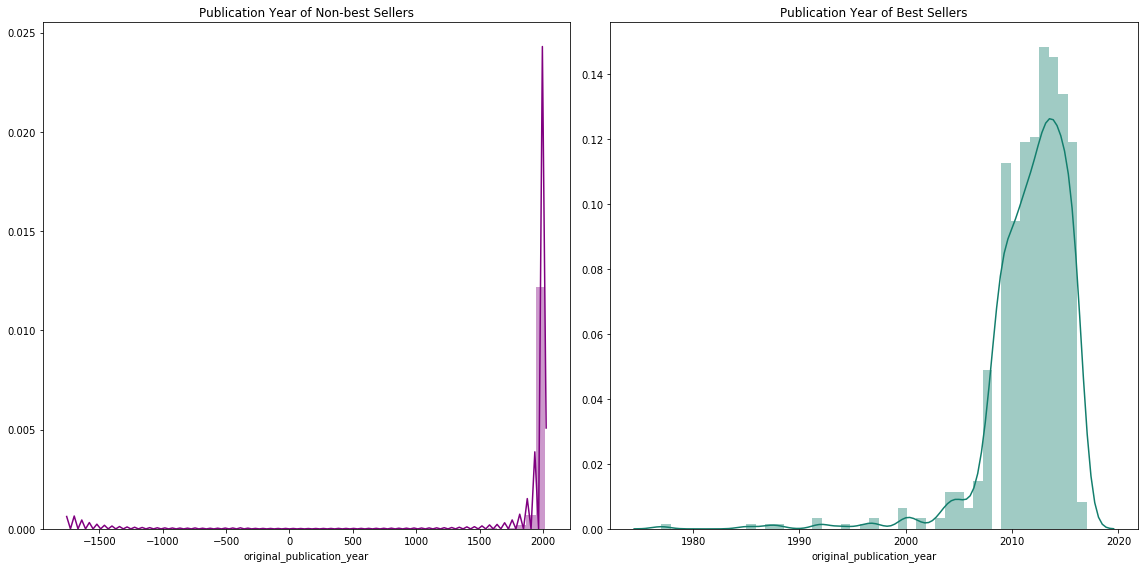

In [56]:
#plot distributions of non-best sellers and best sellers
plt.figure(figsize = (16, 8))
plt.subplot(1, 2, 1)
sns.distplot(other_books['original_publication_year'], color = 'purple')
plt.title('Publication Year of Non-best Sellers')
plt.subplot(1, 2, 2)
sns.distplot(nyt_books['original_publication_year'], color = '#137e6d')
plt.title('Publication Year of Best Sellers')
plt.tight_layout()
plt.show()

We can see from the chart above that there are several books with publication years that were less than 0. I wanted to check whether that stemmed from an error in data collection.

In [57]:
other_books[other_books['original_publication_year'] <0]

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn_x,isbn13_x,authors,original_publication_year,original_title,...,title,highest_rank,weeks_on_list,asterisk,dagger,isbn13,publisher,description,price,author
70,79,1381,1381,3356006,1703,143039954,9.78014e+12,"Homer, Robert Fagles, E.V. Rieu, Frédéric Mugl...",-720.0,Ὀδύσσεια,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
296,341,1371,1371,3293141,1726,140275363,9.78014e+12,"Homer, Robert Fagles, Frédéric Mugler, Bernard...",-750.0,Ἰλιάς,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
355,403,10534,10534,3200649,1865,1590302257,9.78159e+12,"Sun Tzu, Thomas Cleary",-500.0,孫子兵法 [Sūnzi bīngfǎ],...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
688,772,30289,30289,1625515,842,140449140,9.78014e+12,"Plato, Desmond Lee",-380.0,Πολιτεία,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
734,824,1554,1554,3098166,498,1580495931,9.78158e+12,"Sophocles, J.E. Thomas",-430.0,Οἰδίπους Τύραννος,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
975,1099,57854,67896,100074,1265,679776192,9.78068e+12,"Lao Tzu, Gia-Fu Feng, Jane English, Chungliang...",-300.0,道德經 [dào dé jīng],...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
994,1120,21348,21348,868263,942,192840509,9.78019e+12,"Aesop, Laura Harris, Laura Gibbs",-560.0,Aesopica,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1140,1280,12914,12914,288738,830,679729526,9.78068e+12,"Virgil, Robert Fitzgerald",-17.0,Æneis,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1367,1521,7728,7728,1052210,423,1580493882,9.78158e+12,"Sophocles, J.E. Thomas",-441.0,Ἀντιγόνη,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1844,2052,1540,1540,5672,331,015602764X,9.78016e+12,"Sophocles, Dudley Fitts, Elena Bono, Robert Fi...",-401.0,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The books with publication dates of less than 0 are by authors like Homer, Plato, and Confucius, so it makes sense that their publication dates would be less than 0. Since publishers and booksellers would want to use this tool to predict the success of new books, we are only going to include books that were published in years that we have best seller information for, which means starting with 2009.

In [58]:
other_books = other_books[other_books['original_publication_year'] >= 2009]

We also did not include best seller information for children's books in our dataset of best sellers. I will drop the books with these tags from our data.

In [59]:
child_cols = ['children', 'childrens', 'children-s', 'kids', 'children-s-books', 'childrens-books', 'kids-books', 
              'childhood']
for col in child_cols:
    other_books = other_books[other_books[col] == False]
    other_books = other_books.drop([col], axis = 1)
    nyt_books = nyt_books.drop([col], axis = 1)

Now I will combine our set of "other books" with our set of bestsellers. This requires some renaming and column changes.

In [60]:
#prep other books for combining with best sellers
other_books = other_books.rename(columns={'title': 'title_y', 'isbn13': 'isbn13_y'})
other_books = other_books.drop(['isbn_y'], axis = 1)

In [61]:
#combine nyt books and other books
full_book_df = pd.concat([nyt_books, other_books])
full_book_df

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn_x,isbn13_x,authors,original_publication_year,original_title,...,title_y,highest_rank,weeks_on_list,asterisk,dagger,isbn13_y,publisher,description,price,author
10,11,77203,77203,3295919,283,1594480001,9.78159e+12,Khaled Hosseini,2003.0,The Kite Runner,...,THE KITE RUNNER,10.0,107.0,1.0,0.0,9781594480003,Riverhead,An Afghan-American returns to Kabul to learn h...,14.00,Khaled Hosseini
30,31,4667024,4667024,4717423,183,399155341,9.7804e+12,Kathryn Stockett,2009.0,The Help,...,THE HELP,3.0,19.0,0.0,0.0,9780399155345,Amy Einhorn/Putnam,Three women — a white socialite and two black ...,24.95,Kathryn Stockett
34,35,865,865,4835472,458,61122416,9.78006e+12,"Paulo Coelho, Alan R. Clarke",1988.0,O Alquimista,...,THE ALCHEMIST,2.0,344.0,1.0,0.0,9780061122415,HarperOne/HarperCollins,"In this fable, a Spanish shepherd boy ventures...",14.99,Paulo Coelho
45,46,43641,43641,3441236,128,1565125606,9.78157e+12,Sara Gruen,2006.0,Water for Elephants,...,WATER FOR ELEPHANTS,1.0,153.0,1.0,0.0,9781565125605,Algonquin,"Distraught after the death of his parents, a y...",14.95,Sara Gruen
56,57,37435,37435,3275013,125,142001740,9.78014e+12,Sue Monk Kidd,2001.0,The Secret Life of Bees,...,THE SECRET LIFE OF BEES,18.0,29.0,0.0,0.0,9780142001745,Penguin,"In South Carolina in 1964, a teenage girl trie...",15.00,Sue Monk Kidd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9334,9970,6131786,6131786,6310341,24,676979564,9.78068e+12,Ami McKay,2011.0,The Virgin Cure,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9340,9976,6351939,6351939,6538518,24,778325806,9.78078e+12,Maria V. Snyder,2009.0,Sea Glass,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9346,9983,8539798,8539798,8097499,16,2849659266,9.78285e+12,Kazue Kato,2009.0,青の祓魔師 2,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9355,9992,13616278,13616278,19217996,26,575113294,9.78058e+12,Miles Cameron,2012.0,The Red Knight,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


To make our data easier to see, I will remove some more columns. These are a variety of identification columns, columns describing the format of the book, and columns from the best sellers data that we do not have information for for the other books.

In [62]:
full_book_df = full_book_df.drop(['book_id', 'goodreads_book_id', 'best_book_id', 'work_id', 'books_count', 'image_url', 
                   'small_image_url', 'library', 'kindle', 'default', 'ebook', 'audiobook', 'ebooks', 'audiobooks', 
                   'audio', 'e-book', 'books', 'e-books', 'audible', 'audio-books', 'audio-book', 'borrowed', 'paperback',
                  'home-library', 'library-books', 'nook', 'library-book', 'school', 'bookclub', 'bookshelf', 
                  'kindle-books', 'on-kindle', 'asterisk', 'publisher', 'description', 'price', 'book-club',
                                  'english',], axis = 1)
full_book_df['is_bestseller'] = full_book_df['highest_rank'] > 0

For the rest of the tags, I will change those to a binary system of whether or not anyone tagged that book as such. The reason for this is that the number of tags may have been influenced by the fact that it was a bestseller.

In [63]:
tags_list = ['fiction', 'adult', 'novels', 'contemporary', 'series', 'adult-fiction', 'fantasy', 'romance',
             'novel', 'mystery', 'adventure', 'young-adult',  'drama', 'literature', 'general-fiction', 'ya',
             'classics', 'contemporary-fiction', 'historical-fiction', 'historical', 'thriller', 'sci-fi-fantasy', 
             'american', 'suspense', 'sci-fi', 'science-fiction', 'action', 'humor', 'family', 'history', 'non-fiction',
             'calibre', 'crime', 'fantasy-sci-fi', 'chick-lit', '20th-century', 'paranormal', 'classic', 'magic',
             'mystery-thriller', 'teen', 'supernatural', 'nonfiction', 'favorite-authors', 'realistic-fiction',
             'literary-fiction', 'funny', 'scifi-fantasy', 'love', 'part-of-a-series', 'ya-fiction', 'mystery-suspense',
             'mysteries', 'urban-fantasy', 'literary', 'horror', 'young-adult-fiction', 'thrillers', 'british',
             'coming-of-age', 'favorite-series', 'science-fiction-fantasy', 'science', 'friendship', 'general', 'ya-books',
             'scifi', 'action-adventure', 'humour', 'biography', 'speculative-fiction', 'contemporary-romance', 
             'high-school', 'women', 'philosophy', 'war', 'fantasy-scifi', 'mystery-crime', 'usa', 'first-in-series',
             'comedy', 'juvenile', 'suspense-thriller', 'stand-alone', 'england', 'ya-fantasy', 'crime-mystery']
for col in tags_list:
    full_book_df[col] = full_book_df[col] > 0

I will drop the columns that describe less than 100 books in our dataset.

In [64]:
for col in tags_list:
    if full_book_df[col].sum() < 100:
        print(col, full_book_df[col].sum())

classics 61
20th-century 99
classic 16
juvenile 1


In [65]:
full_book_df = full_book_df.drop(['classics', '20th-century', 'classic', 'juvenile'], axis = 1)

In preparation for modeling, I will balance out the best seller and non-best seller groups.

In [66]:
len(full_book_df[full_book_df['is_bestseller'] == False])

2068

In [67]:
df_other = full_book_df[full_book_df['is_bestseller'] == False]
df_bestseller = full_book_df[full_book_df['is_bestseller'] == True]
 
#upsample minority class
df_bestseller_upsampled = resample(df_bestseller, 
                                 replace=True,    
                                 n_samples=2068,    
                                 random_state=123) 
 
#combine majority class with upsampled minority class
full_book_df_upsampled = pd.concat([df_other, df_bestseller_upsampled])
 
#get updated value counts
full_book_df_upsampled['is_bestseller'].value_counts()

True     2068
False    2068
Name: is_bestseller, dtype: int64

Next, we will start modeling. First, I will look at the correlation between variables visually.

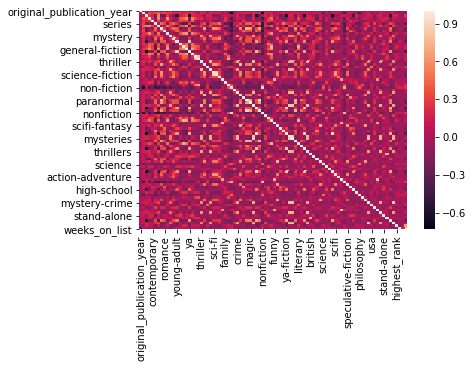

In [68]:
sns.heatmap(full_book_df_upsampled.corr())
plt.show()

There are so many variables that we can not entirely visualize them on this heatmap.

The first model that I will try is a random forest model.

In [69]:
#select variables
X = full_book_df_upsampled.drop(['isbn_x', 'isbn13_x', 'authors', 'original_publication_year', 'original_title', 'title_x',
                                'language_code', 'title_y', 'highest_rank', 'weeks_on_list', 'dagger', 'isbn13_y',
                                 'author', 'is_bestseller'], axis = 1)
#select target
Y = full_book_df_upsampled['is_bestseller']

#define and fit random forest classifier
rfc = ensemble.RandomForestClassifier()
rfc.fit(X, Y)
#get accuracy of random forest classifier
score = cross_val_score(rfc, X, Y, cv=10, scoring = 'accuracy')
print(score)
print('Average Accuracy: %0.2f (+/- %0.2f)' % (score.mean(), score.std() * 2))

[0.92028986 0.88888889 0.88405797 0.88647343 0.87922705 0.91304348
 0.86440678 0.90072639 0.87893462 0.89104116]
Average Accuracy: 0.89 (+/- 0.03)


This is a pretty good starting point for our model! Next, I want to look at the relative feature importance to see which features had the most influence on our model.

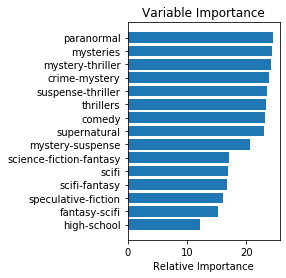

In [70]:
#get feature importance 
feature_importance = rfc.feature_importances_
# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
#limit to top 15 features to visualize
sorted_idx = sorted_idx[:15]
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

A lot of the most important features in our model seem to relate to very specific genres. Next, I will try tuning the hyperparameters for better performance.

In [71]:
#increase n_estimators to 250
rfc = ensemble.RandomForestClassifier(n_estimators = 250)
rfc.fit(X, Y)
#get accuracy of random forest classifier
score = cross_val_score(rfc, X, Y, cv=10, scoring = 'accuracy')
print(score)
print('Average Accuracy: %0.2f (+/- %0.2f)' % (score.mean(), score.std() * 2))

[0.92753623 0.87681159 0.88647343 0.88405797 0.88888889 0.9178744
 0.86440678 0.89104116 0.88619855 0.89588378]
Average Accuracy: 0.89 (+/- 0.04)


On average, this classifier performs similarly to the original classifier.

In [72]:
#change criterion to entropy
rfc = ensemble.RandomForestClassifier(criterion = 'entropy')
rfc.fit(X, Y)
#get accuracy of random forest classifier
score = cross_val_score(rfc, X, Y, cv=10, scoring = 'accuracy')
print(score)
print('Average Accuracy: %0.2f (+/- %0.2f)' % (score.mean(), score.std() * 2))

[0.92270531 0.88164251 0.88405797 0.88647343 0.87681159 0.91304348
 0.86924939 0.88861985 0.87409201 0.89104116]
Average Accuracy: 0.89 (+/- 0.03)


This classifier also performs fairly similarly to the original classifier.

Next, I will try a gradient boost classifier. We will use the same variables as we did for the random forest classifier.

In [73]:
#define gradient boost classifier
clf = ensemble.GradientBoostingClassifier()
clf.fit(X, Y)
#get accuracy of gradient boost classifier
score = cross_val_score(clf, X, Y, cv=10, scoring = 'accuracy')
print(score)
print('Average Accuracy: %0.2f (+/- %0.2f)' % (score.mean(), score.std() * 2))

[0.78019324 0.75845411 0.74637681 0.73913043 0.73913043 0.78502415
 0.73365617 0.75060533 0.70702179 0.75060533]
Average Accuracy: 0.75 (+/- 0.04)


The gradient boosting classifier performs significantly worse than the random forest classifier.

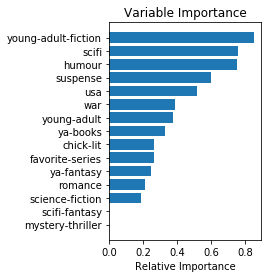

In [74]:
#get feature importance 
feature_importance = clf.feature_importances_
# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
#limit to top 15 features to visualize
sorted_idx = sorted_idx[:15]
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

Interestingly, there is not much overlap between the most important features in the gradient boost classifier and the most important features in the random forest classifier.

In [75]:
#add more estimators
clf = ensemble.GradientBoostingClassifier(n_estimators = 500)
clf.fit(X, Y)
#get accuracy of gradient boost classifier
score = cross_val_score(clf, X, Y, cv=10, scoring = 'accuracy')
print(score)
print('Average Accuracy: %0.2f (+/- %0.2f)' % (score.mean(), score.std() * 2))

[0.83091787 0.79710145 0.79227053 0.78502415 0.82125604 0.83333333
 0.79176755 0.84261501 0.78692494 0.79418886]
Average Accuracy: 0.81 (+/- 0.04)


Adding more estimators significantly improves the accuracy of the model.

In [76]:
#add more estimators
clf = ensemble.GradientBoostingClassifier(n_estimators = 1000)
clf.fit(X, Y)
#get accuracy of gradient boost classifier
score = cross_val_score(clf, X, Y, cv=10, scoring = 'accuracy')
print(score)
print('Average Accuracy: %0.2f (+/- %0.2f)' % (score.mean(), score.std() * 2))

[0.85990338 0.8236715  0.83333333 0.8236715  0.84299517 0.86956522
 0.81113801 0.84261501 0.82082324 0.81840194]
Average Accuracy: 0.83 (+/- 0.04)


Adding even more estimators improves model performance somewhat, but also greatly increase the runtime.

In [77]:
#increase learning rate
clf = ensemble.GradientBoostingClassifier(n_estimators = 1000, learning_rate = 0.5)
clf.fit(X, Y)
#get accuracy of gradient boost classifier
score = cross_val_score(clf, X, Y, cv=10, scoring = 'accuracy')
print(score)
print('Average Accuracy: %0.2f (+/- %0.2f)' % (score.mean(), score.std() * 2))

[0.89613527 0.85507246 0.84299517 0.86231884 0.85990338 0.89855072
 0.84261501 0.85230024 0.85956416 0.86924939]
Average Accuracy: 0.86 (+/- 0.04)


Increasing the learning rate also helps improve the performance, but the gradient boost classifier still does not perform as well as the random forest classifier. Now, we will try a support vector classifier.

In [78]:
#define support vector classifier
svc = SVC()
svc.fit(X ,Y)
#get accuracy of support vector classifier
score = cross_val_score(svc, X, Y, cv=10, scoring = 'accuracy')
print(score)
print('Average Accuracy: %0.2f (+/- %0.2f)' % (score.mean(), score.std() * 2))

[0.82125604 0.76328502 0.77294686 0.79468599 0.77777778 0.82608696
 0.75060533 0.79903148 0.7409201  0.78208232]
Average Accuracy: 0.78 (+/- 0.05)


[[1590  478]
 [ 186 1882]]


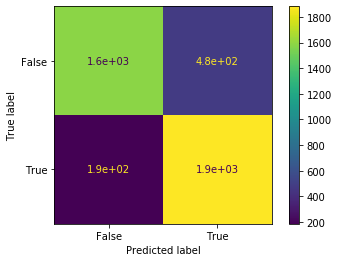

In [79]:
disp = plot_confusion_matrix(svc, X, Y)
print(disp.confusion_matrix)

plt.show()

The support vector classifier does not perform as well as the random forest classifier.

In [80]:
#change kernel to linear
svc = SVC(kernel = 'linear')
svc.fit(X ,Y)
#get accuracy of support vector classifier
score = cross_val_score(svc, X, Y, cv=10, scoring = 'accuracy')
print(score)
print('Average Accuracy: %0.2f (+/- %0.2f)' % (score.mean(), score.std() * 2))

[0.75603865 0.70772947 0.70772947 0.73188406 0.69323671 0.73188406
 0.71186441 0.70460048 0.69007264 0.69491525]
Average Accuracy: 0.71 (+/- 0.04)


[[1267  801]
 [ 343 1725]]


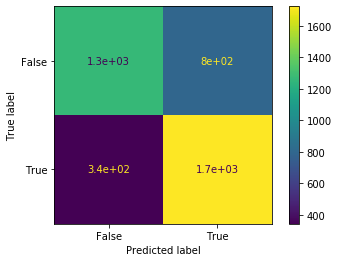

In [81]:
disp = plot_confusion_matrix(svc, X, Y)
print(disp.confusion_matrix)

plt.show()

This classifier performs worse with a linear kernel.

Out of the supervised learning techniques, the random forest classifier performed the best. Now, I will try using some unsupervised clustering techniques.

In [82]:
#select variables
X = full_book_df_upsampled.drop(['isbn_x', 'isbn13_x', 'authors', 'original_publication_year', 'original_title', 'title_x',
                                'language_code', 'title_y', 'highest_rank', 'weeks_on_list', 'dagger', 'isbn13_y',
                                 'author', 'is_bestseller'], axis = 1)
#select target
Y = full_book_df_upsampled['is_bestseller']

#normalize data
X_norm = normalize(X)

#reduce data to two components
X_pca = PCA(2).fit_transform(X_norm)

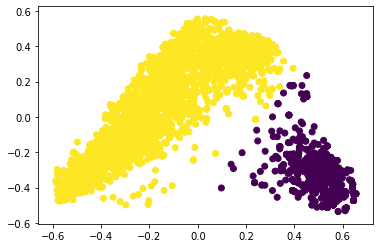

Comparing k-means clusters against the data:
col_0            0     1
is_bestseller           
False          236  1832
True           665  1403


In [83]:
#get predictions
Y_pred = KMeans(n_clusters=2, random_state=42).fit_predict(X_pca)

#plot clusters
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=Y_pred)
plt.show()

#compare clusters with data
print('Comparing k-means clusters against the data:')
print(pd.crosstab(Y, Y_pred))

K-Means Clustering with 2 clusters does a fairly poor job of separating out the two groups, with an accuracy of 60%. I will now try K-Means with 3 clusters.

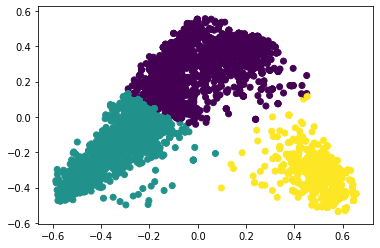

Comparing k-means clusters against the data:
col_0             0     1    2
is_bestseller                 
False           790  1049  229
True           1108   304  656


In [84]:
# Calculate predicted values.
Y_pred = KMeans(n_clusters=3, random_state = 42).fit_predict(X_pca)

# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=Y_pred)
plt.show()

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(Y, Y_pred))

In [85]:
print(pd.crosstab(Y_pred, Y).iloc[1, 0], pd.crosstab(Y_pred, Y).iloc[1, 1])
print(pd.crosstab(Y_pred, Y).iloc[0, 0] + pd.crosstab(Y_pred, Y).iloc[2, 0], pd.crosstab(Y_pred, Y).iloc[0, 1] + pd.crosstab(Y_pred, Y).iloc[2, 1])

1049 304
1019 1764


This model shows some improvement, with an accuracy of 68%; however it does not perform nearly as well as the supervised models. Next, I will try MeanShift clustering.

In [86]:
bandwidth = estimate_bandwidth(X_pca, quantile=0.2, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_pca)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

Number of estimated clusters: 4


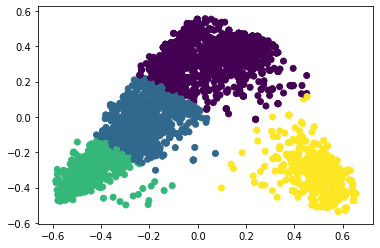

Comparing the assigned categories to the ones in the data:
col_0             0    1    2    3
is_bestseller                     
False           629  634  576  229
True           1014  275  124  655


In [87]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(Y,labels))

In [88]:
print(pd.crosstab(Y, labels).iloc[0, 1] + pd.crosstab(Y, labels).iloc[0, 2], pd.crosstab(Y, labels).iloc[0, 0] + pd.crosstab(Y, labels).iloc[0, 3])
print(pd.crosstab(Y, labels).iloc[1, 1] + pd.crosstab(Y, labels).iloc[1, 2], pd.crosstab(Y, labels).iloc[1, 0] + pd.crosstab(Y, labels).iloc[1, 3])

1210 858
399 1669


MeanShift performed similarly to the K-Means model with 3 clusters, with an accuracy of 69%. I also tried Spectral Clustering, but it did not run within a reasonable amount of time.

Finally, I will use a bag of words model to see if I can predict New York Times best sellers using their titles.

In [89]:
#define text cleaner
def text_cleaner(text):
    text = re.sub('\d','',text)
    text = re.sub('#', '', text)
    text = ' '.join(text.split())
    return text

#clean text - we will use 20% of the data for reasonable runtime
other_string = df_other['title_x'].to_string()
bestseller_string = df_bestseller_upsampled['title_x'].to_string()
other = text_cleaner(other_string[:int(len(other_string)/20)])
bestseller = text_cleaner(bestseller_string[:int(len(bestseller_string)/20)])

In [90]:
#parse text
import en_core_web_sm
nlp = en_core_web_sm.load()
other_doc = nlp(other)
bestseller_doc = nlp(bestseller)
#group into sentences and combine into dataframe
other_titles = [[sent, 'other'] for sent in other_doc.sents]
bestseller_titles = [[sent, 'best-seller'] for sent in bestseller_doc.sents]
titles = pd.DataFrame(other_titles + bestseller_titles)

In [91]:
#function to create list of most common words.
def bag_of_words(text):
    
    #filter out punctuation and stop words
    allwords = [token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop]
    
    #return most common words
    return [item[0] for item in Counter(allwords).most_common(2000)]
    

#create df with common words
def bow_features(sentences, common_words):
    
    #inititalize df
    df = pd.DataFrame(columns=common_words)
    df['text_title'] = sentences[0]
    df['is_bestseller'] = sentences[1]
    df.loc[:, common_words] = 0
    
    #count occurence of words in each title
    for i, sentence in enumerate(df['text_title']):
        
        #filter to lemmas
        words = [token.lemma_
                 for token in sentence
                 if (
                     not token.is_punct
                     and not token.is_stop
                     and token.lemma_ in common_words
                 )]
        
        #get word counts
        for word in words:
            df.loc[i, word] += 1
        
    return df

# Set up the bags.
otherwords = bag_of_words(other_doc)
bestsellerwords = bag_of_words(bestseller_doc)

# Combine bags to create a set of unique words.
common_words = set(otherwords + bestsellerwords)

In [92]:
# Create our data frame with features. This can take a while to run.
word_counts = bow_features(titles, common_words)
word_counts.head()

,Touched,yes,Strings,stay,Bennett,Thompson,stand,Tillman,walk,jump,...,Casual,pendergast,Bully,Hunter,Bridge,Trials,ready,Wave,text_title,is_bestseller
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(The, Fault, in, Our, Stars, Divergent, (, Div...",other
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Catching, Fire, (, The, Hunger, Games, ,, ))",other
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,(Mockingjay),other
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"((, The, Hunger, Games, ,, ), Gone, Girl, Fift...",other
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(The, Maze, Runner, (, Maze, Runner, ,, ), All...",other


Now, I will try running our word counts through a random forest classifier, a logistic regression, and a gradient boosting classifer.

In [93]:
#select variables
X = np.array(word_counts.drop(['text_title','is_bestseller'], 1))
#select target
Y = word_counts['is_bestseller']

#define and fit random forest classifier
rfc = ensemble.RandomForestClassifier()
rfc.fit(X, Y)
#get accuracy of random forest classifier
score = cross_val_score(rfc, X, Y, cv=5, scoring = 'accuracy')
print(score)
print('Average Accuracy: %0.2f (+/- %0.2f)' % (score.mean(), score.std() * 2))

[0.58823529 0.54545455 0.60606061 0.48484848 0.57575758]
Average Accuracy: 0.56 (+/- 0.08)


In [94]:
#define logistic regression
lr = LogisticRegression(penalty='l2')
lr.fit(X, Y)
#get accuracy of logistic regression
score = cross_val_score(lr, X, Y, cv=5, scoring = 'accuracy')
print(score)
print('Average Accuracy: %0.2f (+/- %0.2f)' % (score.mean(), score.std() * 2))

[0.82352941 0.60606061 0.75757576 0.60606061 0.51515152]
Average Accuracy: 0.66 (+/- 0.22)


In [95]:
#define gradient boosting classifier
clf = ensemble.GradientBoostingClassifier()
clf.fit(X, Y)
#get accuracy of gradient boosting classifier
score = cross_val_score(clf, X, Y, cv=5, scoring = 'accuracy')
print(score)
print('Average Accuracy: %0.2f (+/- %0.2f)' % (score.mean(), score.std() * 2))

[0.82352941 0.57575758 0.72727273 0.57575758 0.60606061]
Average Accuracy: 0.66 (+/- 0.20)


The gradient boosting classifer worked the best, closely followed by the logistic regression. Now, I will try adding features for parts of speech and the length of a title to our bag of words model and seeing how the gradient boosting classifier performs.

In [96]:
def bow_features(sentences, common_words):
    
    # Scaffold the data frame and initialize counts to zero.
    df = pd.DataFrame(columns=common_words)
    df['text_title'] = sentences[0]
    df['is_bestseller'] = sentences[1]
    df.loc[:, common_words] = 0
    df['title_length'] = 0
    parts_of_speech = ['PROPN', 'VERB', 'ADJ', 'NOUN', 'ADV', 'INTJ', 'PRON', 'ADP', 'SCONJ', 'NUM', 'DET', 'PUNCT',
                      'CCONJ', 'X']
    for part in parts_of_speech:
        df[part] = 0
    # Process each row, counting the occurrence of words in each sentence.
    for i, sentence in enumerate(df['text_title']):
        
        # Convert the sentence to lemmas, then filter out punctuation,
        # stop words, and uncommon words.
        words = [token.lemma_
                 for token in sentence
                 if (
                     not token.is_punct
                     and not token.is_stop
                     and token.lemma_ in common_words
                 )]
        parts_of_speech = [token.pos_
                           for token in sentence
                           if (
                               not token.is_punct
                               and not token.is_stop
                               and token.lemma_ in common_words
                           )]
        # Populate the row with word counts.
        for word in words:
            df.loc[i, word] += 1
            df.loc[i, 'title_length'] += 1
        for part in parts_of_speech:
            df.loc[i, part] += 1
        
        # This counter is just to make sure the kernel didn't hang.
        if i % 50 == 0:
            print("Processing row {}".format(i))
 
    return df


# Set up the bags.
otherwords = bag_of_words(other_doc)
bestsellerwords = bag_of_words(bestseller_doc)

# Combine bags to create a set of unique words.
common_words = set(otherwords + bestsellerwords)

In [97]:
# Create our data frame with features. This can take a while to run.
word_counts = bow_features(titles, common_words)
word_counts.head()

Processing row 0
Processing row 50
Processing row 100
Processing row 150


,Touched,yes,Strings,stay,Bennett,Thompson,stand,Tillman,walk,jump,...,ADV,INTJ,PRON,ADP,SCONJ,NUM,DET,PUNCT,CCONJ,X
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [98]:
#select variables
X = np.array(word_counts.drop(['text_title','is_bestseller'], 1))
#select target
Y = word_counts['is_bestseller']
#define gradient boosting classifier
clf = ensemble.GradientBoostingClassifier()
clf.fit(X, Y)
#get accuracy of gradient boosting classifier
score = cross_val_score(clf, X, Y, cv=5, scoring = 'accuracy')
print(score)
print('Average Accuracy: %0.2f (+/- %0.2f)' % (score.mean(), score.std() * 2))

[0.67647059 0.51515152 0.66666667 0.60606061 0.60606061]
Average Accuracy: 0.61 (+/- 0.12)


The gradient boost classifer actually performs worse with these new features added.

## Conclusion

In conclusion, the model that works best was the random forest model with genre tags as the input. 

In [99]:
#select variables
X = full_book_df_upsampled.drop(['isbn_x', 'isbn13_x', 'authors', 'original_publication_year', 'original_title', 'title_x',
                                'language_code', 'title_y', 'highest_rank', 'weeks_on_list', 'dagger', 'isbn13_y',
                                 'author', 'is_bestseller'], axis = 1)
#select target
Y = full_book_df_upsampled['is_bestseller']

#define and fit random forest classifier
rfc = ensemble.RandomForestClassifier()
rfc.fit(X, Y)
#get accuracy of random forest classifier
score = cross_val_score(rfc, X, Y, cv=10, scoring = 'accuracy')
print(score)
print('Average Accuracy: %0.2f (+/- %0.2f)' % (score.mean(), score.std() * 2))

[0.92028986 0.87681159 0.87439614 0.87922705 0.88164251 0.91062802
 0.85472155 0.88861985 0.88619855 0.89346247]
Average Accuracy: 0.89 (+/- 0.04)


This tool would allow book publishers to predict whether a particular book would make the New York Times Best Sellers list based on its genres/categorizations. This tool could help guide book publishers in determining what genres of books to publish, as well as whether or not to offer a larger advance to a  particular book based on its genres. The user would be able to input a selection of genres into the model and get a prediction on whether it would be a bestseller. 

Over time, this model would need the updated lists of best sellers to be entered, as well as a corresponding list of new books that were not best sellers to be input. Over time, we would probably want to remove older books to ensure that readers' current tastes were accurately reflected. Other variables could also be added to the model, particularly those that reflect the success of the author, such as number of books written, number of previous best sellers etc. Additionally, the natural language processing model could be extended to use book descriptions rather than book titles to give us a larger volume of text to work with.